In [1]:
import sys
sys.path.append('..')

from diffusion_llms.models.llada import LladaBackbone
import torch
torch.mps.empty_cache()

device = 'mps'  # or 'cuda' for GPU, 'cpu' for CPU

# instantiate the LladaBackbone model
model = LladaBackbone()

/Users/davidebeltrame/opt/miniconda3/envs/dl-nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


In [2]:
model.transformer

ModuleDict(
  (wte): Embedding(126464, 4096)
  (emb_drop): Dropout(p=0.0, inplace=False)
  (ln_f): RMSLayerNorm()
  (blocks): ModuleList(
    (0-31): 32 x LLaDALlamaBlock(
      (dropout): Dropout(p=0.0, inplace=False)
      (act): SiLU()
      (attn_out): Linear(in_features=4096, out_features=4096, bias=False)
      (ff_out): Linear(in_features=12288, out_features=4096, bias=False)
      (rotary_emb): RotaryEmbedding()
      (attn_norm): RMSLayerNorm()
      (ff_norm): RMSLayerNorm()
      (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (ff_proj): Linear(in_features=4096, out_features=12288, bias=False)
      (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
    )
  )
)

In [3]:
model.lm_head

Linear(in_features=4096, out_features=126464, bias=False)

# Plot logits of eos

In [2]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Base")

In [ ]:
import torch
prompt = "Hi, how are you?"
mask_id = 126336

# Ensure tokenizer is defined (from your first cell)
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Base") # Assuming this is still active

prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids # Renamed to prompt_ids for clarity

x = torch.full((1, 1024), mask_id, dtype=torch.long).to(
    model.device
)
# Use prompt_ids.shape[1] if you renamed the variable above
x[:, : prompt_ids.shape[1]] = prompt_ids.clone()

prompt_index = x != mask_id

# Create a dummy target tensor - typically can be zeros or -100 for masked positions
dummy_target = torch.zeros_like(x)  # or torch.full_like(x, -100)

# Pass both input and target to the model and access logits using dictionary key
model_output = model(x, target=dummy_target)
logits = model_output['logits'] # Corrected access to logits
logits = logits[:, :, tokenizer.eos_token_id].squeeze(0)  # (1024)
p = torch.nn.functional.softmax(logits.to(torch.float64), dim=-1)

# You can print p or its shape to see the result
print(p)
print(p.shape)

tensor([1.4851e-08, 4.2744e-07, 9.6567e-08,  ..., 5.8660e-03, 5.8967e-03,
        5.0159e-03], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
torch.Size([1024])


The argmax position is: 1022
The maximum probability value in p is: 5.8967e-03


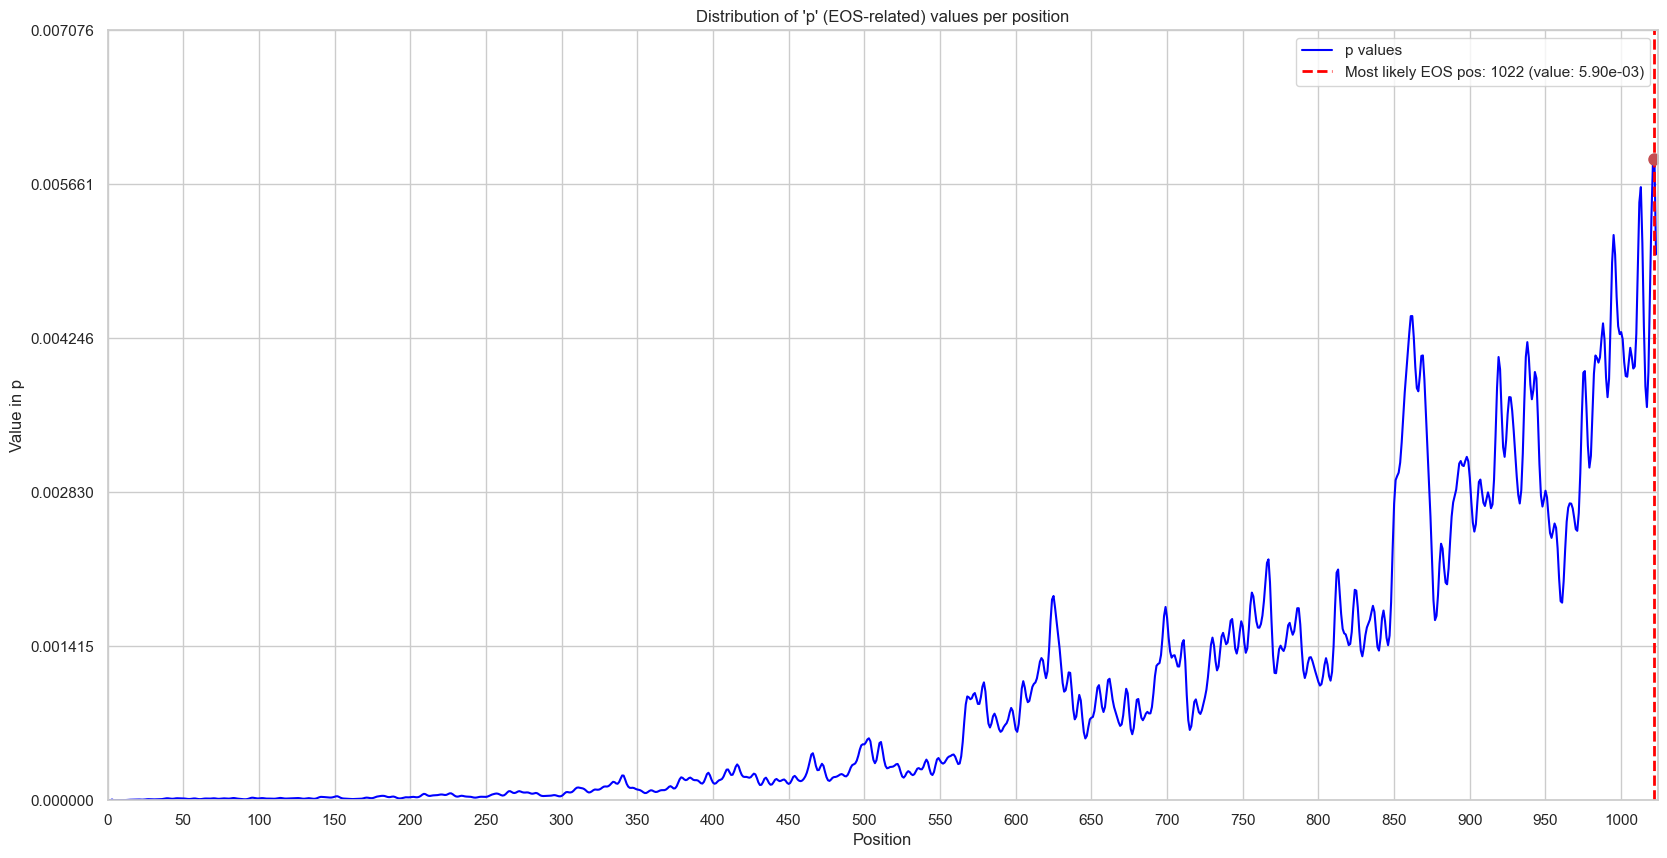

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# plot the distribution of eos probabilities per position

#p = p.detach().cpu().numpy()  # Add .detach() to remove gradient tracking

argmax_pos = np.argmax(p)
max_prob = p[argmax_pos] # This is equivalent to np.max(p)

print(f"The argmax position is: {argmax_pos}")
print(f"The maximum probability value in p is: {max_prob:.4e}") # Using scientific notation for clarity

plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("pastel") # You can keep this or try other palettes

plt.title("Distribution of 'p' (EOS-related) values per position")
plt.xlabel("Position")
plt.ylabel("Value in p") # Changed label to be more general to what p represents

# Plot the distribution of p
plt.plot(p, color='blue', label='p values')

# Set y-limits to zoom into the data range
# Add a small epsilon in case max_prob is zero, though unlikely here.
ylim_top = max_prob * 1.2 if max_prob > 0 else 0.1
plt.ylim(0, ylim_top)

# Create a sensible number of y-ticks within the new range
# For example, 5 ticks from 0 up to ylim_top
plt.yticks(np.linspace(0, ylim_top, num=6))

plt.xticks(np.arange(0, 1024, step=50))
plt.xlim(0, 1024) # Or perhaps xlim(0, len(p)-1)

plt.axvline(x=argmax_pos, color='red', linestyle='--', linewidth=2, label=f'Most likely EOS pos: {argmax_pos} (value: {max_prob:.2e})')
# You can also add a small marker at the peak
plt.plot(argmax_pos, max_prob, 'ro', markersize=8) # 'ro' is red circle

plt.legend() # Show labels for the plot line and the axvline
plt.grid(True) # Ensure grid is on
plt.show()